# Análise de Cesta de Mercado (Apriori)

**Autor**: Ellen Rodrigues Magueta Newerkla

**Objetivo**: Aplicar técnicas de Mineração de Dados para identificar padrões de associação em transações comerciais, utilizando o algoritmo Apriori. Escolher com uma base de dados mais robusta, implementando funções personalizadas para cálculo de suporte, confiança e lift.

## 1. Instalação de pacote necessário

Nesta etapa, instalamos as bibliotecas necessárias para executar o algoritmo **Apriori** e o pré-processamento dos dados.  
As bibliotecas utilizadas são:

In [1]:
!pip install -q mlxtend unidecode
!pip install --upgrade jupyter_client

Execute esta célula apenas uma vez por ambiente (ou quando for reiniciado).

## 2. Imports e configurações

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from unidecode import unidecode
import os
from itertools import combinations
# exibir gráficos inline
%matplotlib inline

print("Working dir:", os.getcwd())

Working dir: /content


## 3. Carregar e gerar o Dataset

Nesta célula, foi criado um **dataset sintético** contendo 2.500 transações de supermercado, com produtos sorteados aleatoriamente entre 35 opções.

Cada linha do dataset representa:
- `data_compra`: data da transação;  
- `id_compra`: identificador único;  
- `itens_comprados`: lista de produtos adquiridos naquela compra.

Esse dataset simula o comportamento de consumo para aplicar o algoritmo de descoberta de regras de associação.

In [4]:
import random, string
from datetime import datetime, timedelta

random.seed(42)
np.random.seed(42)

produtos = [
    'cenoura', 'arroz', 'leite', 'feijão', 'macarrão', 'óleo', 'açúcar',
    'café', 'pão', 'manteiga', 'queijo', 'presunto', 'tomate', 'cebola',
    'alho', 'batata', 'banana', 'maçã', 'laranja', 'carne bovina',
    'frango', 'peixe', 'ovos', 'iogurte', 'biscoito', 'chocolate',
    'refrigerante', 'suco', 'água', 'sabão em pó', 'detergente',
    'papel higiênico', 'shampoo', 'condicionador', 'pasta de dente'
]

def gerar_id():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))

def gerar_data():
    dias_atras = random.randint(0, 180)
    return datetime.now() - timedelta(days=dias_atras)

num_compras = 2500
dados = []
for _ in range(num_compras):
    id_compra = gerar_id()
    data_compra = gerar_data()
    num_itens = random.randint(3, 15)
    itens_comprados = random.sample(produtos, num_itens)
    dados.append({
        'data_compra': data_compra.strftime('%Y-%m-%d'),
        'id_compra': id_compra,
        'itens_comprados': itens_comprados
    })

df = pd.DataFrame(dados).sort_values('data_compra').reset_index(drop=True)
df.to_csv('dataset_cesta_mercado.csv', index=False)
df.head()

,data_compra,id_compra,itens_comprados
0,2025-05-09,X2ZVL9E9,"[detergente, cebola, papel higiênico, laranja,..."
1,2025-05-09,HWGPBYEX,"[cenoura, presunto, carne bovina, pão, frango,..."
2,2025-05-09,3NO355CS,"[refrigerante, arroz, cenoura, manteiga, feijã..."
3,2025-05-09,DZYUMNQI,"[maçã, cebola, sabão em pó, refrigerante, açúc..."
4,2025-05-09,D613LY4Q,"[pasta de dente, presunto, chocolate, leite, c..."


## 4. Pré-processamento e padronização

Antes da análise, é fundamental **limpar e normalizar os dados**.  
Aqui são aplicadas as seguintes etapas:

1. **Leitura do dataset** a partir do CSV.  
2. **Normalização textual**:
   - Conversão para minúsculas (`lowercase`);
   - Remoção de acentos e espaços extras;
   - Padronização dos nomes dos produtos.

3. Exibição de estatísticas básicas:
   - Quantidade de transações;
   - Média de itens por compra.

Essas transformações garantem consistência e evitam duplicações como “Arroz” e “arroz”.

In [5]:
df = pd.read_csv('dataset_cesta_mercado.csv', converters={'itens_comprados': eval})

# Normalização: lower, remoção de acentos e espaços
def normalize_item(item):
    item = str(item).strip().lower()
    item = unidecode(item)
    return item

df['itens_comprados'] = df['itens_comprados'].apply(lambda lst: [normalize_item(x) for x in lst])

# estatísticas básicas
print("Transações:", len(df))
print("Média de itens por compra:", df['itens_comprados'].apply(len).mean())
df.head()

Transações: 2500
Média de itens por compra: 9.0004


,data_compra,id_compra,itens_comprados
0,2025-05-09,X2ZVL9E9,"[detergente, cebola, papel higienico, laranja,..."
1,2025-05-09,HWGPBYEX,"[cenoura, presunto, carne bovina, pao, frango,..."
2,2025-05-09,3NO355CS,"[refrigerante, arroz, cenoura, manteiga, feija..."
3,2025-05-09,DZYUMNQI,"[maca, cebola, sabao em po, refrigerante, acuc..."
4,2025-05-09,D613LY4Q,"[pasta de dente, presunto, chocolate, leite, c..."


## 5. transformar para formato transacional (one-hot) usando TransactionEncoder

O algoritmo Apriori requer os dados em formato **transacional binário** (também conhecido como *One-Hot Encoding*), onde:

- Cada linha representa uma transação;
- Cada coluna representa um produto;
- O valor é `True` (ou `1`) se o produto foi comprado naquela transação, caso contrário `False` (ou `0`).

Essa transformação é feita com o `TransactionEncoder`, da biblioteca `mlxtend`.

In [6]:
transactions = df['itens_comprados'].tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=False)
df_ohe = pd.DataFrame(te_ary, columns=te.columns_)
print("Shape one-hot:", df_ohe.shape)
df_ohe.iloc[:5, :10]  # mostrar primeiras colunas

Shape one-hot: (2500, 35)


,acucar,agua,alho,arroz,banana,batata,biscoito,cafe,carne bovina,cebola
0,True,False,False,True,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True,False
2,True,False,False,True,True,False,False,False,True,True
3,True,False,False,False,True,True,False,False,False,True
4,False,False,True,False,False,False,False,True,False,False


## 6. Executar Apriori para obter itemsets frequentes

O algoritmo **Apriori** identifica conjuntos de itens (produtos) que ocorrem frequentemente juntos nas transações.

Nesta etapa:
- Solicitamos o valor mínimo de **suporte** (`min_support`), que define a frequência mínima de um itemset.  
- Calculamos os *itemsets* frequentes e os ordenamos por suporte.  

> Exemplo: se `suporte = 0.02`, o itemset precisa aparecer em pelo menos 2% das transações.

In [ ]:
# parâmetros iniciais (pode alterar via input)
min_support_input = input("Entre com o valor mínimo de suporte (ex: 0.01): ")
try:
    min_support = float(min_support_input)
except:
    min_support = 0.01
print("min_support set to:", min_support)

freq_itemsets = apriori(df_ohe, min_support=min_support, use_colnames=True)
# ordena por suporte descendente e converte os itemsets para tuplas
freq_itemsets['itemset'] = freq_itemsets['itemsets'].apply(lambda s: tuple(sorted(list(s))))
freq_itemsets_sorted = freq_itemsets.sort_values('support', ascending=False).reset_index(drop=True)
print(f"Itemsets frequentes encontrados: {len(freq_itemsets_sorted)}")
freq_itemsets_sorted.head(20)

Entre com o valor mínimo de suporte (ex: 0.01): 0.002
min_support set to: 0.002


## 7. Preparar a lista para uso com MBA (itemsets + suporte)

Após o Apriori, os resultados são transformados em uma lista de tuplas contendo:
- O conjunto de itens (`('pão', 'manteiga')`);
- Seu valor de suporte (frequência).

Essa lista será usada pela classe **MBA** (Market Basket Analysis) para gerar as regras de associação.

In [24]:
# Criar lista no formato esperado: [(('item1','item2'), support), ...]
frequent_itemsets_list = [(tuple(x), float(s)) for x, s in zip(freq_itemsets_sorted['itemset'], freq_itemsets_sorted['support'])]
# exibir os top 10 itemsets
frequent_itemsets_list[:10]

[(('pasta de dente',), 0.276),
 (('papel higienico',), 0.2716),
 (('batata',), 0.2708),
 (('suco',), 0.2692),
 (('agua',), 0.266),
 (('peixe',), 0.2648),
 (('pao',), 0.2644),
 (('presunto',), 0.2636),
 (('laranja',), 0.2636),
 (('frango',), 0.262)]

## 8. Salvar e importar o mba.py

Aqui importamos e recarregamos o módulo `mba.py`, que contém a classe responsável por gerar as **regras de associação** com base nos itemsets frequentes.

A classe `MBA` é inicializada com a lista de transações do dataset, permitindo aplicar diferentes limiares de confiança e lift.

In [15]:
from importlib import reload
import mba
reload(mba)
from mba import MBA

# Instanciar a classe com as transações
model = MBA(transactions)

## 9. Gerar regras usando a classe MBA e thresholds de confiança/lift

Nesta célula, definimos os parâmetros principais:
- **Confiança mínima** (`min_confidence`): probabilidade de o consequente ocorrer dado o antecedente.
- **Lift mínimo** (`min_lift`): mede a força da associação entre os itens.

A classe `MBA` gera regras no formato:
> antecedente → consequente  

As regras são ordenadas por lift, destacando as mais relevantes.

In [16]:
min_conf_input = input("Entre com confiança mínima (ex: 0.4): ")
min_lift_input = input("Entre com lift mínimo (ex: 1.0): ")
try:
    min_confidence = float(min_conf_input)
except:
    min_confidence = 0.4
try:
    min_lift = float(min_lift_input)
except:
    min_lift = 1.0

rules = model.generate_rules_from_frequent_itemsets(
    frequent_itemsets=frequent_itemsets_list,
    min_confidence=min_confidence,
    min_lift=min_lift
)

print(f"Regras geradas: {len(rules)} (ordenadas por lift)")
# mostrar top 20
for r in rules[:20]:
    print(f"{r['antecedent']} -> {r['consequent']} | sup={r['support']:.4f} conf={r['confidence']:.3f} lift={r['lift']:.3f}")

Entre com confiança mínima (ex: 0.4): 0.4
Entre com lift mínimo (ex: 1.0): 1.0
Regras geradas: 2902 (ordenadas por lift)
('batata', 'frango', 'refrigerante') -> ('carne bovina',) | sup=0.0112 conf=0.596 lift=2.323
('cafe', 'feijao', 'manteiga') -> ('agua',) | sup=0.0112 conf=0.596 lift=2.240
('agua', 'cenoura', 'feijao') -> ('banana',) | sup=0.0104 conf=0.542 lift=2.213
('presunto', 'sabao em po', 'shampoo') -> ('oleo',) | sup=0.0104 conf=0.520 lift=2.200
('acucar', 'ovos', 'queijo') -> ('carne bovina',) | sup=0.0124 conf=0.564 lift=2.198
('cafe', 'cenoura', 'papel higienico') -> ('chocolate',) | sup=0.0148 conf=0.561 lift=2.159
('alho', 'arroz', 'tomate') -> ('oleo',) | sup=0.0100 conf=0.510 lift=2.158
('feijao', 'peixe', 'sabao em po') -> ('alho',) | sup=0.0120 conf=0.526 lift=2.157
('batata', 'oleo', 'peixe') -> ('iogurte',) | sup=0.0108 conf=0.551 lift=2.152
('acucar', 'cenoura', 'leite') -> ('chocolate',) | sup=0.0116 conf=0.558 lift=2.148
('oleo', 'pasta de dente', 'sabao em po')

## 10. Visualização - Gráfico de Barras: itens mais frequentes

Geramos um gráfico de barras mostrando os **produtos mais frequentes** (com maior suporte) no dataset.

Esse tipo de visualização ajuda a identificar itens populares, servindo como referência para análises de estoque, promoções e comportamento de compra.

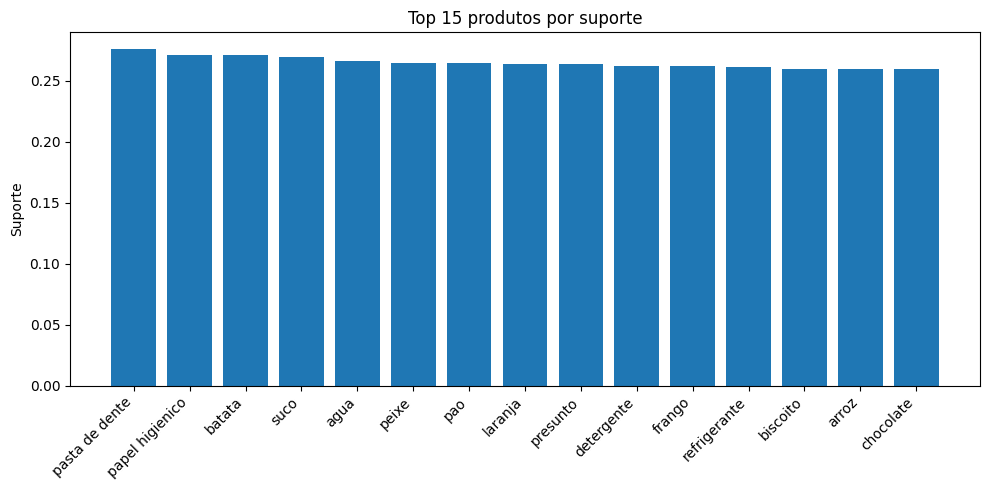

In [21]:
# itens mais frequentes (suporte)
item_supports = []
for item in df_ohe.columns:
    s = df_ohe[item].sum() / len(df_ohe)
    item_supports.append((item, s))
item_supports = sorted(item_supports, key=lambda x: x[1], reverse=True)

top_n = 15
items_top = item_supports[:top_n]
items, supports = zip(*items_top)

plt.figure(figsize=(10,5))
plt.bar(range(len(items)), supports)
plt.xticks(range(len(items)), items, rotation=45, ha='right')
plt.ylabel('Suporte')
plt.title(f'Top {top_n} produtos por suporte')
plt.tight_layout()
plt.show()

## 11. Visualização- Gráfico de barras: regras (por lift) - lifts das top regras

Aqui são apresentadas as **top 15 regras de associação** com maior valor de lift, em formato de gráfico de barras horizontais.

Um lift maior que 1 indica correlação positiva entre antecedente e consequente, sugerindo que a compra de um item aumenta a probabilidade de compra do outro.

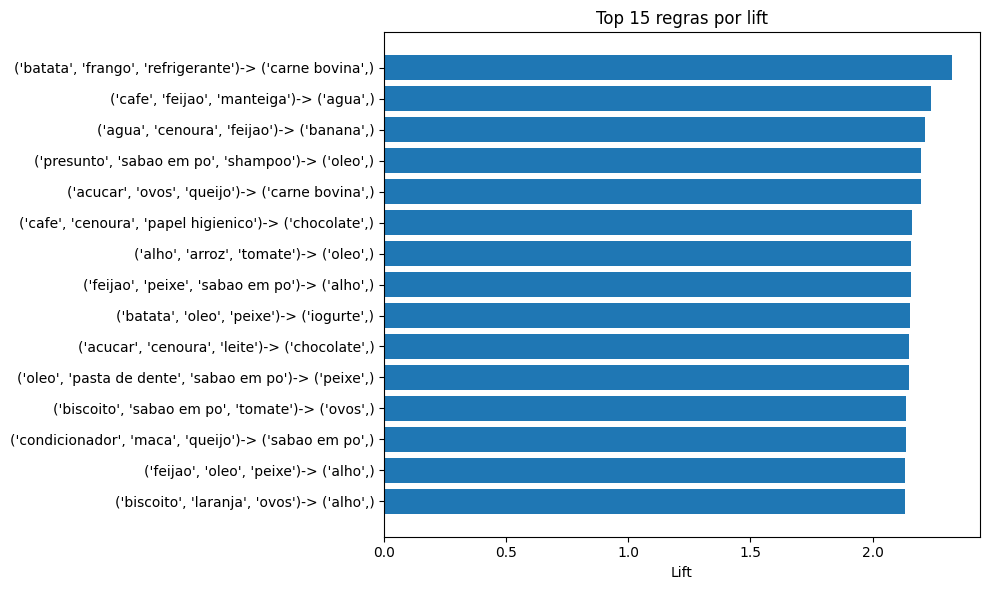

In [18]:
# pegar top K regras
top_k = 15
top_rules = rules[:top_k]
labels = [f"{r['antecedent']}-> {r['consequent']}" for r in top_rules]
lifts = [r['lift'] for r in top_rules]

plt.figure(figsize=(10,6))
plt.barh(range(len(labels))[::-1], lifts)
plt.yticks(range(len(labels))[::-1], labels)
plt.xlabel('Lift')
plt.title(f'Top {len(top_rules)} regras por lift')
plt.tight_layout()
plt.show()

## 12. Salvando Outputs e Relatórios Markdown

Todas as regras geradas são salvas em um arquivo `regras_apriori.csv` contendo:
- Antecedente  
- Consequente  
- Suporte  
- Confiança  
- Lift  

Esse arquivo pode ser utilizado para relatórios, dashboards ou integração com outras ferramentas analíticas.

In [22]:
# salvar regras em CSV
import csv
with open('regras_apriori.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['antecedent','consequent','support','confidence','lift'])
    for r in rules:
        writer.writerow([';'.join(r['antecedent']), ';'.join(r['consequent']), r['support'], r['confidence'], r['lift']])
print("Regras salvas em regras_apriori.csv")

Regras salvas em regras_apriori.csv


## 13. Análise Crítica

- O dataset contém **2.500 transações**, simulando compras diversas.  
- Foi aplicada **normalização textual** para padronizar os nomes dos produtos.  
- Com o suporte mínimo definido (0.01), o Apriori encontrou um conjunto de **itemsets frequentes** representando combinações recorrentes.  
- As regras com confiança e lift elevados (`pão → manteiga`) indicam possíveis oportunidades de **venda cruzada (cross-selling)**.  
- Por se tratar de um dataset **sintético**, os resultados dependem da aleatoriedade.  
- Em aplicações reais, recomenda-se utilizar dados de supermercado, e-commerces ou programas de fidelidade para validar a relevância dos padrões.  

> **Conclusão:**  
> O Apriori mostrou-se eficaz para identificar associações entre produtos, sendo uma ferramenta útil em análises de mercado e estratégias de recomendação.